In [ ]:
import numpy as np
import pandas as pd
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy import ones

import os

from matplotlib import pyplot as plt

import tensorflow as tf
from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import RMSprop, Adam
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/My Drive/Datasets'

/content/drive/My Drive/Datasets


In [ ]:
cwd = os.getcwd()
os.chdir(cwd)
print(os.listdir('/content/drive/My Drive/Datasets/celeba'))

['images']


In [ ]:
path_celeb = []
train_path_celeb = "/content/drive/My Drive/Datasets/celeba/images"
for path in os.listdir(train_path_celeb):
    if '.jpg' in path:
        path_celeb.append(os.path.join(train_path_celeb, path))

In [ ]:
new_path=path_celeb[0:1000]

In [ ]:
len(new_path)

1000

In [ ]:
crop = (30, 55, 150, 175) #croping size for the image so that only the face at centre is obtained
images = [np.array((Image.open(path).crop(crop)).resize((64,64))) for path in new_path]

images = np.array(images)

In [ ]:
train_data=images

In [ ]:
print(path_celeb)

['/content/drive/My Drive/Datasets/celeba/images/052851.jpg', '/content/drive/My Drive/Datasets/celeba/images/153353.jpg', '/content/drive/My Drive/Datasets/celeba/images/170127.jpg', '/content/drive/My Drive/Datasets/celeba/images/155435.jpg', '/content/drive/My Drive/Datasets/celeba/images/150704.jpg', '/content/drive/My Drive/Datasets/celeba/images/073359.jpg', '/content/drive/My Drive/Datasets/celeba/images/090177.jpg', '/content/drive/My Drive/Datasets/celeba/images/161186.jpg', '/content/drive/My Drive/Datasets/celeba/images/189541.jpg', '/content/drive/My Drive/Datasets/celeba/images/177496.jpg', '/content/drive/My Drive/Datasets/celeba/images/063200.jpg', '/content/drive/My Drive/Datasets/celeba/images/003691.jpg', '/content/drive/My Drive/Datasets/celeba/images/157783.jpg', '/content/drive/My Drive/Datasets/celeba/images/005534.jpg', '/content/drive/My Drive/Datasets/celeba/images/083659.jpg', '/content/drive/My Drive/Datasets/celeba/images/159689.jpg', '/content/drive/My Driv

In [ ]:
len(path_celeb)

36978

In [ ]:
print(train_data.shape)

(1000, 64, 64, 3)


<Figure size 1000x1000 with 0 Axes>

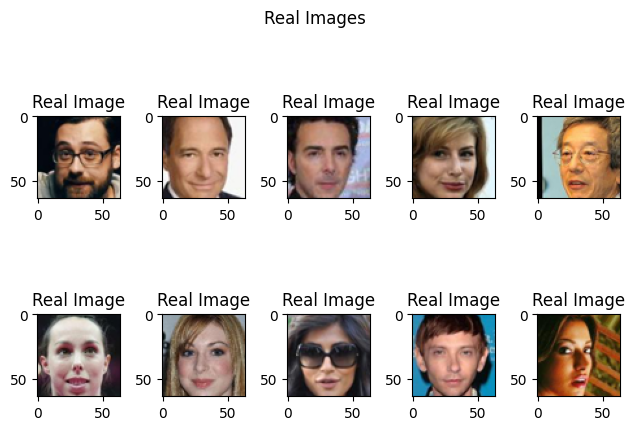

In [ ]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=10

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(train_data[idx].reshape(64,64,3))

            idx+=10

plt.tight_layout()
plt.show()

In [ ]:
def define_discriminator(image_shape=(64, 64, 3)):
    model = Sequential()

    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same', input_shape=image_shape))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0002)
    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

discr = define_discriminator()
print(discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [ ]:
def define_generator(latent_dim, channels=3):
    model = Sequential()

    model.add(Dense(16 * 16 * 128, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((16, 16, 128)))

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(channels, (8, 8), activation='tanh', padding='same'))

    return model

gen = define_generator(100)
print(gen.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             3309568   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 128)      262272    
 ranspose)                                            

In [ ]:
def define_gan(generator, discriminator):
  discriminator.trainable = False

  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  opt = Adam(lr=0.0001)
  model.compile(loss = 'binary_crossentropy', optimizer =opt, metrics=['accuracy'])

  return model

In [ ]:
def load_real_samples():
  X_train = train_data
  X = X_train.astype('float32')

  X = (X-127.5)/127.5

  return X

In [ ]:
def generate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))

  return X, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
  X_input = randn(latent_dim*n_samples)
  X_input = X_input.reshape(n_samples, latent_dim)

  return X_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
  X_input = generate_latent_points(latent_dim, n_samples)
  X = generator.predict(X_input)
  y = zeros((n_samples, 1 ))
  return X, y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128 ):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  #bat_per_epo = 100 # for time

  half_batch = int(n_batch / 2)

  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake  = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)


      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))

      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      print(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss)

  g_model.save('/content/drive/MyDrive/Model/generator_model3.h5')

In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=100)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 1s 6ms/step
1 1 7 0.7200711965560913 0.6959114670753479 [0.6898182034492493, 1.0]
2/2 [==============================] - 0s 12ms/step
1 2 7 0.5159392356872559 0.701124906539917 [0.6838558912277222, 1.0]
2/2 [==============================] - 0s 11ms/step
1 3 7 0.37206700444221497 0.7107812166213989 [0.673923134803772, 1.0]
2/2 [==============================] - 0s 11ms/step
1 4 7 0.24469751119613647 0.7258108854293823 [0.6583566665649414, 1.0]
2/2 [==============================] - 0s 11ms/step
1 5 7 0.14782437682151794 0.7485496997833252 [0.6391851902008057, 1.0]
2/2 [==============================] - 0s 12ms/step
1 6 7 0.09266114234924316 0.7744131088256836 [0.6178342700004578, 1.0]
2/2 [==============================] - 0s 11ms/step
1 7 7 0.06300413608551025 0.802645742893219 [0.5954092741012573, 1.0]
2/2 [==============================] - 0s 11ms/step
2 1 7 0.04235324263572693 0.8302074670791626 [0.5779070854187012, 1.0]
2/2 [=================

50 7 7 0.3771284520626068 0.3074899911880493 [3.902991771697998, 0.015625]


In [ ]:
def show_plot(examples, n ):
  for i in range(n*n):
    plt.subplot(n, n , i + 1)
    plt.axis('off')
    plt.imshow(examples[i, :, :, :])
  plt.show()

1/1 [==============================] - 1s 598ms/step


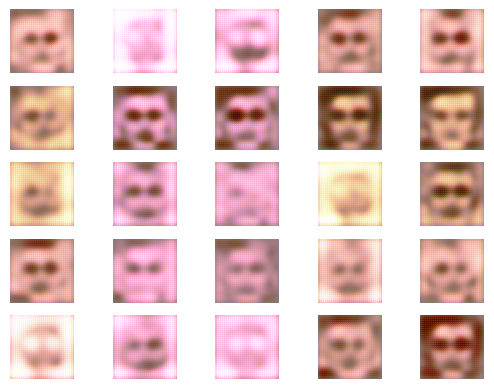

In [ ]:
model = load_model('/content/drive/My Drive/Model/generator_model3.h5')
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
X = (X + 1) / 2

import numpy as np
X = (X*255).astype(np.uint8)


show_plot(X, 5)